### Selecting airport hubs for a new airline

The problem of facility location is common to industries that have physical locations, "facilities", and need to identify the best location to put new facilities as their business grows. Typically, one would want to place these facilities in a manner that maximizes the number of customers that they can serve. There are numerous examples of this, ranging from chain stores and restaurants trying to open new locations to placing public electric car charging stations. A common thread among these examples is that, generally, many locations have already been picked out and cannot be moved. 

A simple strategy would be to choose locations based on their total number of people. However, this approach would leave people in lower density areas completely unserved, while some large cities may get multiple locations. Put another way, there may be redundancy among the people who are served. 

A more complex strategy may involve using a clustering approach where each potential location is encoded as an example weighted by the number of people at the location. Using k-medoids or some other approach guarantees that an exact location is picked. However, this approach has the significant downside that, when placing a new facility, one would have to re-run the clustering algorithm with a larger number of clusters and it's likely impossible to move currently existing facilities. Potentially, one could run a clustering approach initially with a large number of clusters, but this has the downside of having to make an approximation as to the number of locations one wishes to open while also meaning that no location is at an ideal location.

Submodular optimization provides an appealing framework for this task. Other notebooks go more in depth, but essentially, submodular optimization is a greedy optimization strategy that iteratives selects examples that minimize redundancy with those that have already been chosen. The greedy nature of the algorithm means that, at each iteration, the algorithm is selecting the best next example, which is convenient when you can't move previous facilities.

There are many functions that one could apply submodular optimization to. However, this problem is such a canonical use of submodular optimization that there is a function named the "facility location" function. The functiont takes the form

\begin{equation}
f(X) = \sum\limits_{x} \max\limits_{y} \phi(x, y)
\end{equation}
where $x$ is an example from your data set, or potential locations in this case, and $y$ is a facility that has already been selected, and $\phi$ is a similarity measure between the two. Potentially this is the physical distance between $x$ and $y$.

Let's say you're a new airline and you want to know where to put your hubs. These hubs might be at locations that get the most traffic. However, you don't neessarily want to select only the most trafficked areas, you want to select areas that you're currently not serving well.

This is a problem for facility location.

In [1]:
%pylab inline
numpy.random.seed(0)

import pandas
import seaborn; seaborn.set_style('whitegrid')

from apricot import FeatureBasedSelection
from apricot import FacilityLocationSelection

Populating the interactive namespace from numpy and matplotlib


### Loading the Data

For this example we'll use two tables from openflights.org. The first table contains information about airports around the world and the second table contains information about recorded routes. A limitation of this data is that it was updated most recently in 2014.

Let's first load up the airport table. Because we are focusing on the United States, we will filter out the airports from other parts of the world.

In [2]:
names = 'Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz', 'Type', 'Source'
airports = pandas.read_csv("airports.csv", header=None, names=names)
airports = airports[airports['Country'] == 'United States']
airports.head()

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source
3212,3411,Barter Island LRRS Airport,Barter Island,United States,BTI,PABA,70.134003,-143.582001,2,-9,A,America/Anchorage,airport,OurAirports
3213,3412,Wainwright Air Station,Fort Wainwright,United States,\N,PAWT,70.613403,-159.860001,35,-9,A,America/Anchorage,airport,OurAirports
3214,3413,Cape Lisburne LRRS Airport,Cape Lisburne,United States,LUR,PALU,68.875099,-166.110001,16,-9,A,America/Anchorage,airport,OurAirports
3215,3414,Point Lay LRRS Airport,Point Lay,United States,PIZ,PPIZ,69.732903,-163.005005,22,-9,A,America/Anchorage,airport,OurAirports
3216,3415,Hilo International Airport,Hilo,United States,ITO,PHTO,19.721399,-155.048004,38,-10,N,Pacific/Honolulu,airport,OurAirports


Next, let's load up the routes. These routes include a source airport, which is where the flight began, and a destination airport, which is where the plane was flying to.

In [3]:
names = 'Airline', 'Airline ID', 'Source ', 'Source ID', 'Destination', 'Destination ID', 'Codeshare', 'Stops', 'Equipment'
routes = pandas.read_csv("routes.csv", header=None, names=names)
routes = routes.replace("\\N", numpy.nan).dropna()
routes['Source ID'] = routes['Source ID'].astype(int)
routes['Destination ID'] = routes['Destination ID'].astype(int)
routes = routes.dropna()
routes.head()

,Airline,Airline ID,Source,Source ID,Destination,Destination ID,Codeshare,Stops,Equipment
187,2P,897,GES,2402,MNL,2397,Y,0,320
197,2P,897,MNL,2397,GES,2402,Y,0,320
1059,4M,3201,DFW,3670,EZE,3988,Y,0,777
1060,4M,3201,EZE,3988,DFW,3670,Y,0,777
1061,4M,3201,EZE,3988,JFK,3797,Y,0,777


### Data Visualization

We can start off by visualizing the longitude and latitude of each airport in our data set.

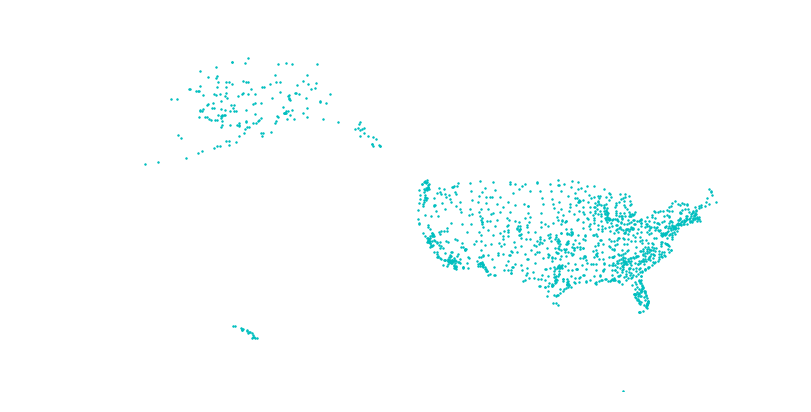

In [4]:
plt.figure(figsize=(14, 7))
plt.scatter(airports['Longitude'], airports['Latitude'], s=2, color='c')
plt.xlim(-200, -50)
plt.ylim(10, 80)

plt.axis('off')
plt.show()

That shape seems familiar.

Next, we can perform two table joins in order to get the latitude and longitude of the sorce and destination airports for each flight. This will let us visualize the routes.

In [5]:
routes_reduced = routes[['Source ID', 'Destination ID']]
airports_reduced = airports[['Airport ID', 'Latitude', 'Longitude']]

routes_merged = pandas.merge(routes_reduced, airports_reduced, left_on='Source ID', right_on='Airport ID')
routes_merged = pandas.merge(routes_merged, airports_reduced, left_on='Destination ID', right_on='Airport ID', suffixes=('_source', '_destination'))
routes_merged = routes_merged.drop(['Airport ID_destination', 'Airport ID_source'], axis=1)
routes_merged.head()

,Source ID,Destination ID,Latitude_source,Longitude_source,Latitude_destination,Longitude_destination
0,3670,3718,32.896801,-97.038002,32.411301,-99.681900
1,3670,3700,32.896801,-97.038002,31.611300,-97.230499
2,3670,3852,32.896801,-97.038002,31.327400,-92.549797
3,3682,3852,33.636700,-84.428101,31.327400,-92.549797
4,3682,3852,33.636700,-84.428101,31.327400,-92.549797


Now let's add the flights to the plot.

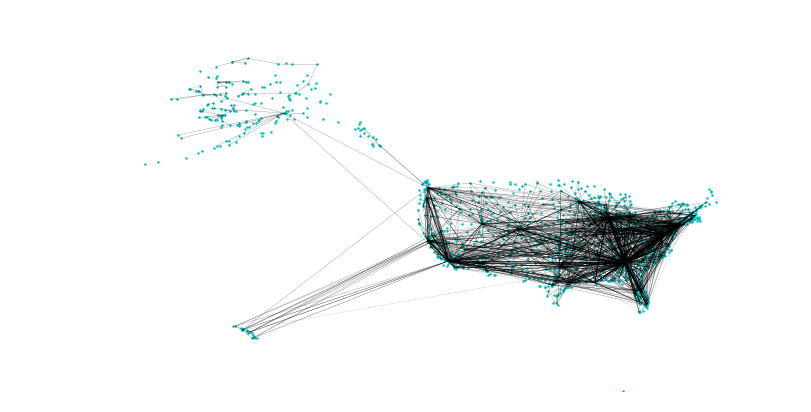

In [6]:
plt.figure(figsize=(14, 7))
plt.scatter(airports['Longitude'], airports['Latitude'], s=2, color='c')
for i, (_, _, la_x, lo_x, la_y, lo_y) in routes_merged.iterrows():
    plt.plot([lo_x, lo_y], [la_x, la_y], color='k', linewidth=0.08)
    
plt.xlim(-200, -50)
plt.ylim(10, 80)

plt.axis('off')
plt.show()

### Airport selection using the most routes

We can already see some hubs forming. It looks like Atlanta is a clear hub on the east coast, Chicago is a clear hub north of it, and Los Angeles is a clear hub on the bottom left. Let's check to see whether this is supported by the number of routes involving each airport.

In [7]:
n = len(airports)
mapping = {airport: i for i, airport in enumerate(airports['Airport ID'])}

route_map = numpy.zeros((n, n))
for _, (source, destination) in routes_reduced.iterrows():
    if source in mapping and destination in mapping:
        x, y = mapping[source], mapping[destination]
        route_map[x, y] = 1
        route_map[y, x] = 1
        
route_map.sum()

3404.0

In [64]:
airports_w_routes = airports.copy()
airports_w_routes['# Routes'] = [route_map[mapping[airport]].sum() for airport in airports['Airport ID']]
airports_w_routes.sort_values("# Routes", ascending=False).head(6)

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source,# Routes
3482,3682,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,ATL,KATL,33.636700,-84.428101,1026,-5,A,America/New_York,airport,OurAirports,146.0
3630,3830,Chicago O'Hare International Airport,Chicago,United States,ORD,KORD,41.978600,-87.904800,672,-6,A,America/Chicago,airport,OurAirports,117.0
3551,3751,Denver International Airport,Denver,United States,DEN,KDEN,39.861698,-104.672997,5431,-7,A,America/Denver,airport,OurAirports,107.0
3658,3858,Minneapolis-St Paul International/Wold-Chamber...,Minneapolis,United States,MSP,KMSP,44.882000,-93.221802,841,-6,A,America/Chicago,airport,OurAirports,79.0
3470,3670,Dallas Fort Worth International Airport,Dallas-Fort Worth,United States,DFW,KDFW,32.896801,-97.038002,607,-6,A,America/Chicago,airport,OurAirports,76.0
3350,3550,George Bush Intercontinental Houston Airport,Houston,United States,IAH,KIAH,29.984400,-95.341400,97,-6,A,America/Chicago,airport,OurAirports,71.0


Looks like it is.

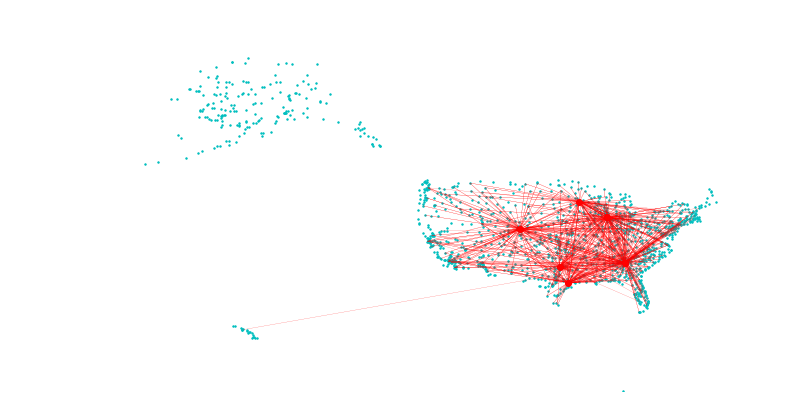

In [65]:
airports_ = airports_w_routes.sort_values("# Routes", ascending=False).head(6)
airport_idxs = airports_['Airport ID'].values
d = {}

plt.figure(figsize=(14, 7))
plt.scatter(airports['Longitude'], airports['Latitude'], s=2, color='c')
plt.scatter(airports_['Longitude'], airports_['Latitude'], color='r')

for i, (sid, did, la_x, lo_x, la_y, lo_y) in routes_merged.iterrows():
    if (sid, did) in d:
        continue
        
    if int(sid) in airport_idxs or int(did) in airport_idxs:
        d[(sid, did)] = True
        plt.plot([lo_x, lo_y], [la_x, la_y], color='r', linewidth=0.15)

plt.xlim(-200, -50)
plt.ylim(10, 80)

plt.axis('off')
plt.show()

How can we quantitatively evaluate this selection of airports? We can measure it using the the number  of unique routes that contain the set of airports, either as the source or as the destination.

In [15]:
most_routes = numpy.array([mapping[airport] for airport in airports_w_routes.sort_values("# Routes", ascending=False)['Airport ID'].iloc[:6]])
route_map[most_routes].max(axis=0).sum()

256.0

It looks like this set of airports spans 256 different unique routes. That seems like a high value.

### Airport selection by optimizing facility location

Now let's use facility location to select the set of six airports.

In [10]:
model = FacilityLocationSelection(6, pairwise_func='precomputed')
model.fit(route_map)

airports_w_routes.iloc[model.ranking].head(6)

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source,# Routes
3482,3682,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,ATL,KATL,33.636700,-84.428101,1026,-5,A,America/New_York,airport,OurAirports,146.0
3551,3751,Denver International Airport,Denver,United States,DEN,KDEN,39.861698,-104.672997,5431,-7,A,America/Denver,airport,OurAirports,107.0
3630,3830,Chicago O'Hare International Airport,Chicago,United States,ORD,KORD,41.978600,-87.904800,672,-6,A,America/Chicago,airport,OurAirports,117.0
3470,3670,Dallas Fort Worth International Airport,Dallas-Fort Worth,United States,DFW,KDFW,32.896801,-97.038002,607,-6,A,America/Chicago,airport,OurAirports,76.0
3399,3599,Bethel Airport,Bethel,United States,BET,PABE,60.779800,-161.837997,126,-9,A,America/Anchorage,airport,OurAirports,17.0
3377,3577,Seattle Tacoma International Airport,Seattle,United States,SEA,KSEA,47.449001,-122.308998,433,-8,A,America/Los_Angeles,airport,OurAirports,53.0


Let's take a look at where these airports lie across the United States.

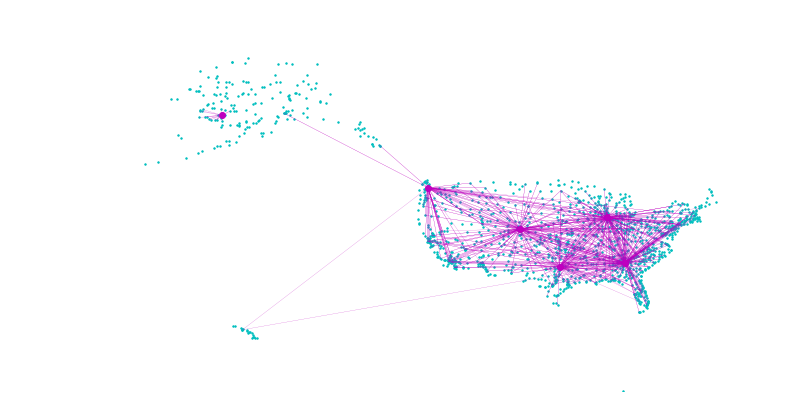

In [63]:
airports_ = airports_w_routes.iloc[model.ranking]
airport_idxs = airports_['Airport ID'].values
d = {}

plt.figure(figsize=(14, 7))
plt.scatter(airports['Longitude'], airports['Latitude'], s=2, color='c')
plt.scatter(airports_['Longitude'], airports_['Latitude'], color='m')

for i, (sid, did, la_x, lo_x, la_y, lo_y) in routes_merged.iterrows():
    if (sid, did) in d:
        continue
    
    if int(sid) in airport_idxs or int(did) in airport_idxs:
        d[(sid, did)] = True
        plt.plot([lo_x, lo_y], [la_x, la_y], color='m', linewidth=0.15)

plt.xlim(-200, -50)
plt.ylim(10, 80)

plt.axis('off')
plt.show()